Esse Notebook foi criado como um modelo baseline de regressão linear utilizando dados estruturadas e não estruturados para estimar a produtividade de soja em qualquer município brasileiro

**1. Configurações**

In [ ]:
#Instalação do pacote geemap
%pip install geemap

In [ ]:
#Importando os pacotes que vamos precisar para modelagem e comunicação com o Google Earth Engine
import ee
import geemap
import requests
import pandas as pd
import json
import time
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_val_predict,
)
#Importar os pacotes para treinamento dos modelos de regressão e série temporal
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from xgboost import XGBRegressor


%matplotlib inline



In [ ]:
# Autenticar no Earth Engine
ee.Authenticate()

# Inicializar o Earth Engine. Precisa logar com seu token
ee.Initialize()

**2. Definição do município, anos e escalas da regressão - Usuário Define**

In [ ]:
# As duas entradas fornecidas pelo usuário - Geocódigo do município a ser estimado e a escala da redução.
# Para municípios com grande área territorial (Centro-Oeste, MATOPIBA), trabalhar com pelo menos 500m de escala
# Se der erro ou demorar muito o processamento, aumentar a escala
# Definir o range da série que vamos treinar e testar nossos dados, o último ano é aberto no intervalo.

GEOCODE = '5211909'
Escala = 500;
ano = list(range(2000, 2022))


**3. Obtenção e pré-processamento dos dados do dataset**


In [ ]:
# Obter os limites territorias do município direto da API de Malha Municipal do IBGE

url = f'http://servicodados.ibge.gov.br/api/v3/malhas/municipios/{GEOCODE}?formato=application/vnd.geo+json'
response = requests.get(url)
geo = response.json();
ee_object = geemap.geojson_to_ee(geo)
geometry = ee_object.geometry()

In [ ]:
Map = geemap.Map(center=[-11.77,-45.76], zoom=8)

Map.addLayer(geometry, {}, "Geometria")

Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.

Map


Map(center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [ ]:
#Se precisar especificar a geometria manualmente no mapa

#Map.draw_features
#roi = ee.FeatureCollection(Map.draw_features)
#geometry = roi.geometry()
#Map

In [ ]:
#Função desenvolvida para fazer uma classificação não supervisionada a cada ano e pegar as 2 classes com maiores valor de EVI
# O objetivo é não precisar calculcar o EVI médio no município inteiro e sim nas classes com maior probabilidade de serem plantio.
# A partir disso temos o EVI dessas classes para cada município e podemos utilizar essa feature em nossa regressão


def clusterization(image):

          
    # Load a pre-computed Landsat composite for input.
    input = image.clip(geometry).select("EVI");
  
    #Make the training dataset.
    training = input.sample(**{
    'region': geometry,
    'scale': Escala,
    'numPixels': 5000
    });

    #Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(5).train(training)
    #Cluster the input using the trained clusterer.
    result = input.cluster(clusterer)
 
    #Combine the mean and standard deviation reducers.
    reducers = ee.Reducer.mean()

    #Inicialização Lista de EVI dos clustes
    lista = ee.List([])

    #Iteração sobre os 5 Clusters para calcular a estatística de cada região
    for i in range(5):

        #Cálculo da geometria
        geom = result.select("cluster").eq(i).selfMask().reduceToVectors(**{
        'scale':Escala,
        });



        #Reducer para cálculo do EVI médio de cada cluster
        stats = image.reduceRegion(**{
        'reducer': reducers,
        'geometry':geom.geometry(),
        'scale':Escala,
        'bestEffort':True,
        'maxPixels':10000000000,
        });

        #Armarzena o EVI médio de cada clúster em uma lista
        lista = lista.add(stats.get("EVI"));


    #Cópia da Lista para ordenar os 2 maiores EVIs
    lista2 = lista;


    #Ordenar a lista para pegar os 2 maiores valores de EVI médio nos clusters
    #Agora nossos clustests de interesse estão nas posições 3 e 4 da lista 2
    lista2 = lista2.sort()

    #Pegar as chaves dos clusteres de interesse na lista original
    chaves1 = lista.indexOf(lista2.get(3))
    chaves2 = lista.indexOf(lista2.get(4))


    #Cálculo da Geometria final

    geom1 = result.select("cluster").eq(chaves1).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    geom2 = result.select("cluster").eq(chaves2).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    #Geom é a feature collection de nossos clusters de interesse
    geom = geom1.merge(geom2);



    stats = image.reduceRegion(**{
    'reducer': reducers,
    'geometry':geom.geometry(),
    'scale':Escala,
    'bestEffort':True,
    'maxPixels':10000000000,
    });


    return image.set('EVI_Cluster', stats.get("EVI"))
    



In [ ]:
#Inicializando a lista que vai receber as informações de EVI médio do Google Earth Engine

stats = list();

#String com o último ano que vamos utilizar em algumas extrações
anofim = str(ano[-1])

#Corrigindo o ano pra o plot
tempox =  [i - 2000 for i in ano]

In [ ]:
#Dividir o processamento das imagens de acordo com o ano para não sobrecarregar o GEE

    
for i in (ano):
    
    print ("Safra",i-1,"/",i)
    #Filtrar a territorialidade 
    #4 principais meses de safra - SOJA  NOV/FEV    
    mcollection = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i-1) + '-11-01', str(i-1) +'-12-31').filter(ee.Filter.calendarRange(11, 12,'month')).map(clusterization)
    mcollection2 = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i) + '-01-01', str(i) +'-02-28').filter(ee.Filter.calendarRange(1, 2,'month')).map(clusterization)    
    mcollection = mcollection.merge(mcollection2)
    
    #Pegar a propriedade que nos interessa em cada imagem - o EVI_Cluster Calculado 
    a = mcollection.aggregate_array('EVI_Cluster')
    
    
    #10s de soneca pra o GEE não derrubar as requests
    time.sleep(10)
    # Fazer a informação passar do servidor do google para o jupyter
    x = a.getInfo()
    #Salvar cada ano
    stats.append(x)    
    

Safra 1999 / 2000
Safra 2000 / 2001
Safra 2001 / 2002
Safra 2002 / 2003
Safra 2003 / 2004
Safra 2004 / 2005
Safra 2005 / 2006
Safra 2006 / 2007
Safra 2007 / 2008
Safra 2008 / 2009
Safra 2009 / 2010
Safra 2010 / 2011
Safra 2011 / 2012
Safra 2012 / 2013
Safra 2013 / 2014
Safra 2014 / 2015
Safra 2015 / 2016
Safra 2016 / 2017
Safra 2017 / 2018
Safra 2018 / 2019
Safra 2019 / 2020
Safra 2020 / 2021


In [ ]:
#Montando nosso Dataframe de EVIs
df = pd.DataFrame({'lin':stats})

#Renomeando as colunas
df = pd.DataFrame(stats, columns = ['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8'])

#Criando features médias
df['average_EVI12'] = df[['EVI1', 'EVI2']].mean(axis=1)
df['average_EVI34'] = df[['EVI3', 'EVI4']].mean(axis=1)
df['average_EVI56'] = df[['EVI5', 'EVI6']].mean(axis=1)
df['average_EVI78'] = df[['EVI7', 'EVI8']].mean(axis=1)
df['max_EVI'] = df[['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8']].max(axis=1)
df['average_EVI'] = df[['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8']].mean(axis=1)

#Correção dos meses sem ponto
df.fillna(0)

#Visualização de nosso Dataframe de EVI
df

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,average_EVI12,average_EVI34,average_EVI56,average_EVI78,max_EVI,average_EVI
0,5593.690208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5593.690208,NaN,NaN,NaN,5593.690208,5593.690208
1,4960.013121,5432.041456,6949.164628,7409.062150,6506.878157,6057.176972,5835.216205,NaN,5196.027289,7179.113389,6282.027565,5835.216205,7409.062150,6164.221813
2,4527.636588,5721.247820,6826.451543,7698.649148,7386.078449,7016.344840,6595.940024,5742.321986,5124.442204,7262.550346,7201.211644,6169.131005,7698.649148,6439.333800
3,4115.911586,5581.883202,6912.250704,7749.662453,7512.625860,6321.926548,6114.611187,5460.059827,4848.897394,7330.956578,6917.276204,5787.335507,7749.662453,6221.116421
4,4263.695913,4812.380830,6553.360241,7146.897329,7209.192248,6870.044244,6327.652508,5652.350472,4538.038371,6850.128785,7039.618246,5990.001490,7209.192248,6104.446723
5,4359.851890,5920.173303,7415.473479,6834.841669,6867.578423,7113.561123,5876.919824,NaN,5140.012597,7125.157574,6990.569773,5876.919824,7415.473479,6341.199959
6,4415.112005,5740.082941,7082.308050,7474.613674,7871.699157,7150.740053,6505.250507,5523.728931,5077.597473,7278.460862,7511.219605,6014.489719,7871.699157,6470.441915
7,4704.294080,4963.878221,6244.488414,7987.367774,7397.196591,6700.152498,5318.244128,4861.868356,4834.086150,7115.928094,7048.674545,5090.056242,7987.367774,6022.186258
8,4360.549773,4561.108449,6384.467929,8162.761853,7749.686557,6998.788578,6925.291197,6011.052554,4460.829111,7273.614891,7374.237568,6468.171876,8162.761853,6394.213361
9,5226.863982,6911.854999,8271.898687,7578.242249,6757.864383,6204.238832,4948.388403,NaN,6069.359491,7925.070468,6481.051608,4948.388403,8271.898687,6557.050219


In [ ]:
#Toda a parte de dados metereológicos já está rodando normalmente no modelo. Contudo, nessa modelagem não vamos utilizar 
# por conta da incosistência e indisponibilidade dos dados de estações do INMET para algumas regiões do país

#Identificação da Estação mais próxima

url = f'https://apiprevmet3.inmet.gov.br/estacao/proxima/{GEOCODE}'
response = requests.get(url).json()

#Tratar os casos que não temos respostas da estação
keys_list = list(response)
key = keys_list[0]

response

{'dados': {'CD_ESTACAO': 'A016',
  'CHUVA': '0',
  'DC_NOME': 'JATAÍ',
  'DT_MEDICAO': '2022-02-15',
  'HR_MEDICAO': '1200',
  'PRE_INS': '938.9',
  'PRE_MAX': '938.9',
  'PRE_MIN': '938.2',
  'PTO_INS': '20.9',
  'PTO_MAX': '21.4',
  'PTO_MIN': '20.3',
  'RAD_GLO': '1799.733',
  'TEM_INS': '24.9',
  'TEM_MAX': '25.1',
  'TEM_MIN': '22.6',
  'TEM_SEN': '26.1',
  'UF': 'GO',
  'UMD_INS': '79',
  'UMD_MAX': '87',
  'UMD_MIN': '78',
  'VEN_DIR': '275',
  'VEN_RAJ': '3.8',
  'VEN_VEL': '1.5',
  'VL_LATITUDE': '-17.923622',
  'VL_LONGITUDE': '-51.717467'},
 'estacao': {'CODIGO': 'A016',
  'DISTANCIA_EM_KM': '2',
  'GEOCODE': '5211909',
  'LATITUDE': '-17.923622',
  'LONGITUDE': '-51.717467',
  'NOME': 'JATAÍ',
  'REGIAO': 'CO',
  'UF': 'GO'}}

In [ ]:
#Identificação do Código da estação
if key != "error":
  estacao = response['dados']['CD_ESTACAO']

In [ ]:
#Puxar dados históricos da estação identificada
if key != "error":

  new_url = f'https://apitempo.inmet.gov.br/estacao/diaria/1999-11-01/{anofim}-04-30/{estacao}'
  json_response = requests.get(new_url).json()
  dados_estacao = pd.DataFrame(json_response)
  print(dados_estacao)

     UMID_MED  DT_MEDICAO DC_NOME  ... VEL_VENTO_MED CD_ESTACAO VL_LONGITUDE
0        None  1999-11-01   JATAÍ  ...          None       A016   -51.717467
1        None  1999-11-02   JATAÍ  ...          None       A016   -51.717467
2        None  1999-11-03   JATAÍ  ...          None       A016   -51.717467
3        None  1999-11-04   JATAÍ  ...          None       A016   -51.717467
4        None  1999-11-05   JATAÍ  ...          None       A016   -51.717467
...       ...         ...     ...  ...           ...        ...          ...
7847     72.5  2021-04-26   JATAÍ  ...           0.5       A016   -51.717467
7848       73  2021-04-27   JATAÍ  ...             1       A016   -51.717467
7849     71.8  2021-04-28   JATAÍ  ...           0.7       A016   -51.717467
7850     67.5  2021-04-29   JATAÍ  ...           0.9       A016   -51.717467
7851     71.3  2021-04-30   JATAÍ  ...             1       A016   -51.717467

[7852 rows x 13 columns]


In [ ]:
#Tratamento das datas
if key != "error":

  dados_estacao['CHUVA'] = dados_estacao['CHUVA'].astype(float)
  dados_estacao['DT_MEDICAO'] = pd.to_datetime(dados_estacao['DT_MEDICAO'])
  dados_estacao['ANO'] = dados_estacao['DT_MEDICAO'].dt.year
  dados_estacao['MES'] = dados_estacao['DT_MEDICAO'].dt.month
  print(dados_estacao)

     UMID_MED DT_MEDICAO DC_NOME UMID_MIN  ... CD_ESTACAO  VL_LONGITUDE   ANO MES
0        None 1999-11-01   JATAÍ     None  ...       A016    -51.717467  1999  11
1        None 1999-11-02   JATAÍ     None  ...       A016    -51.717467  1999  11
2        None 1999-11-03   JATAÍ     None  ...       A016    -51.717467  1999  11
3        None 1999-11-04   JATAÍ     None  ...       A016    -51.717467  1999  11
4        None 1999-11-05   JATAÍ     None  ...       A016    -51.717467  1999  11
...       ...        ...     ...      ...  ...        ...           ...   ...  ..
7847     72.5 2021-04-26   JATAÍ       43  ...       A016    -51.717467  2021   4
7848       73 2021-04-27   JATAÍ       41  ...       A016    -51.717467  2021   4
7849     71.8 2021-04-28   JATAÍ       31  ...       A016    -51.717467  2021   4
7850     67.5 2021-04-29   JATAÍ       29  ...       A016    -51.717467  2021   4
7851     71.3 2021-04-30   JATAÍ       47  ...       A016    -51.717467  2021   4

[7852 rows x 15

In [ ]:
#Correção dos dados omissos
if key != "error":

  b  = dados_estacao.groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [ ]:
#Construção da feature com os valores acumulados por mês durante a safra - NOV - ABR
if key != "error":

  mask = (dados_estacao['MES'] <= 4) | (dados_estacao['MES'] >= 11)  
  b = dados_estacao.loc[mask].groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)
  print(b)

ANO   MES
1999  11       0.0
      12       0.0
2000  1        0.0
      2        0.0
      3        0.0
             ...  
2020  12     308.0
2021  1      306.6
      2       83.4
      3      165.4
      4       77.0
Name: CHUVA, Length: 132, dtype: float64


In [ ]:
#Construção do Dataframe com as features de pluviosidade
if key != "error":

  chuva = b.values.reshape(22,6)
  df2 = pd.DataFrame(chuva, columns = ['C_NOV', 'C_DEZ','C_JAN','C_FEV','C_MAR','C_ABR'])
  print(df2)

    C_NOV  C_DEZ  C_JAN  C_FEV  C_MAR  C_ABR
0     0.0    0.0    0.0    0.0    0.0    0.0
1     0.0    0.0    0.0    0.0    0.0    0.0
2     0.0    0.0    0.0    0.0    0.0    0.0
3     0.0    0.0    0.0    0.0    0.0    0.0
4     0.0    0.0    0.0    0.0    0.0    0.0
5     0.0    0.0    0.0    0.0    0.0    0.0
6     0.0    0.0    0.0    0.0    0.0    0.0
7     0.0    0.0    0.0    0.0    0.0    0.0
8   145.0  245.8  309.4  321.8  356.6  205.8
9   187.6  219.8  146.4  215.4  222.8   56.2
10  281.0  328.4  169.0  208.0  348.8  166.6
11  199.6  209.0  238.2  238.2  353.8   90.2
12  122.0  192.4  330.4  319.2  228.2  181.0
13  280.2  154.2  257.6  183.4  298.4  149.0
14  143.6  219.8  139.8  180.0  247.2  218.4
15  275.6  306.8   88.8  248.0  266.2  118.2
16  117.4  153.8  213.8  207.8  264.8   25.2
17  179.0  346.8  193.2  106.0   50.0    0.0
18  347.4  248.2  243.0  219.2  184.4   67.4
19  223.6  219.0  189.0  102.4  221.2  160.6
20   76.4  228.2  198.0  264.6  103.2   70.8
21   80.2 

In [ ]:
#Construção do Dataframe com as features de EVI e Pluviosidade
if key != "error":

  concat_data = pd.concat([df,df2],axis=1).fillna(0)

else:

  concat_data = df

In [ ]:
#Visualização do Dataframe
concat_data

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,average_EVI12,average_EVI34,average_EVI56,average_EVI78,max_EVI,average_EVI,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,5593.690208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5593.690208,0.000000,0.000000,0.000000,5593.690208,5593.690208,0.0,0.0,0.0,0.0,0.0,0.0
1,4960.013121,5432.041456,6949.164628,7409.062150,6506.878157,6057.176972,5835.216205,0.000000,5196.027289,7179.113389,6282.027565,5835.216205,7409.062150,6164.221813,0.0,0.0,0.0,0.0,0.0,0.0
2,4527.636588,5721.247820,6826.451543,7698.649148,7386.078449,7016.344840,6595.940024,5742.321986,5124.442204,7262.550346,7201.211644,6169.131005,7698.649148,6439.333800,0.0,0.0,0.0,0.0,0.0,0.0
3,4115.911586,5581.883202,6912.250704,7749.662453,7512.625860,6321.926548,6114.611187,5460.059827,4848.897394,7330.956578,6917.276204,5787.335507,7749.662453,6221.116421,0.0,0.0,0.0,0.0,0.0,0.0
4,4263.695913,4812.380830,6553.360241,7146.897329,7209.192248,6870.044244,6327.652508,5652.350472,4538.038371,6850.128785,7039.618246,5990.001490,7209.192248,6104.446723,0.0,0.0,0.0,0.0,0.0,0.0
5,4359.851890,5920.173303,7415.473479,6834.841669,6867.578423,7113.561123,5876.919824,0.000000,5140.012597,7125.157574,6990.569773,5876.919824,7415.473479,6341.199959,0.0,0.0,0.0,0.0,0.0,0.0
6,4415.112005,5740.082941,7082.308050,7474.613674,7871.699157,7150.740053,6505.250507,5523.728931,5077.597473,7278.460862,7511.219605,6014.489719,7871.699157,6470.441915,0.0,0.0,0.0,0.0,0.0,0.0
7,4704.294080,4963.878221,6244.488414,7987.367774,7397.196591,6700.152498,5318.244128,4861.868356,4834.086150,7115.928094,7048.674545,5090.056242,7987.367774,6022.186258,0.0,0.0,0.0,0.0,0.0,0.0
8,4360.549773,4561.108449,6384.467929,8162.761853,7749.686557,6998.788578,6925.291197,6011.052554,4460.829111,7273.614891,7374.237568,6468.171876,8162.761853,6394.213361,145.0,245.8,309.4,321.8,356.6,205.8
9,5226.863982,6911.854999,8271.898687,7578.242249,6757.864383,6204.238832,4948.388403,0.000000,6069.359491,7925.070468,6481.051608,4948.388403,8271.898687,6557.050219,187.6,219.8,146.4,215.4,222.8,56.2


In [ ]:
#Request para obter os dados de rendimento histórico do SIDRA - IBGE

url3 = f'https://apisidra.ibge.gov.br/values/t/5457/n6/{GEOCODE}/v/112/p/last%{anofim}/c782/40124'
json_response = requests.get(url3).json()
produtividade = pd.DataFrame(json_response)
Y = produtividade['V'].iloc[1:].values.ravel()
#Corrigir os anos que vem sem informação do SIDRA
Y = np.where((Y =='...') | (Y =='-'),0,Y)
Y

array(['2940', '2940', '2885', '3180', '3000', '2518', '2700', '3000',
       '3300', '3120', '3060', '3600', '3552', '3360', '2760', '2940',
       '2800', '3720', '3600', '3700', '3720'], dtype=object)

In [ ]:
#Criar a coluna com o rendimento do ano anterior como input da série temporal
X = np.zeros(Y.size+1)
X[1:] =  Y[:]
X
df3 = pd.DataFrame(X, columns = ['Y_t-1'])
concat_data = pd.concat([concat_data,df3],axis=1).fillna(0)
concat_data

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,average_EVI12,average_EVI34,average_EVI56,average_EVI78,max_EVI,average_EVI,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR,Y_t-1
0,5593.690208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5593.690208,0.000000,0.000000,0.000000,5593.690208,5593.690208,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4960.013121,5432.041456,6949.164628,7409.062150,6506.878157,6057.176972,5835.216205,0.000000,5196.027289,7179.113389,6282.027565,5835.216205,7409.062150,6164.221813,0.0,0.0,0.0,0.0,0.0,0.0,2940.0
2,4527.636588,5721.247820,6826.451543,7698.649148,7386.078449,7016.344840,6595.940024,5742.321986,5124.442204,7262.550346,7201.211644,6169.131005,7698.649148,6439.333800,0.0,0.0,0.0,0.0,0.0,0.0,2940.0
3,4115.911586,5581.883202,6912.250704,7749.662453,7512.625860,6321.926548,6114.611187,5460.059827,4848.897394,7330.956578,6917.276204,5787.335507,7749.662453,6221.116421,0.0,0.0,0.0,0.0,0.0,0.0,2885.0
4,4263.695913,4812.380830,6553.360241,7146.897329,7209.192248,6870.044244,6327.652508,5652.350472,4538.038371,6850.128785,7039.618246,5990.001490,7209.192248,6104.446723,0.0,0.0,0.0,0.0,0.0,0.0,3180.0
5,4359.851890,5920.173303,7415.473479,6834.841669,6867.578423,7113.561123,5876.919824,0.000000,5140.012597,7125.157574,6990.569773,5876.919824,7415.473479,6341.199959,0.0,0.0,0.0,0.0,0.0,0.0,3000.0
6,4415.112005,5740.082941,7082.308050,7474.613674,7871.699157,7150.740053,6505.250507,5523.728931,5077.597473,7278.460862,7511.219605,6014.489719,7871.699157,6470.441915,0.0,0.0,0.0,0.0,0.0,0.0,2518.0
7,4704.294080,4963.878221,6244.488414,7987.367774,7397.196591,6700.152498,5318.244128,4861.868356,4834.086150,7115.928094,7048.674545,5090.056242,7987.367774,6022.186258,0.0,0.0,0.0,0.0,0.0,0.0,2700.0
8,4360.549773,4561.108449,6384.467929,8162.761853,7749.686557,6998.788578,6925.291197,6011.052554,4460.829111,7273.614891,7374.237568,6468.171876,8162.761853,6394.213361,145.0,245.8,309.4,321.8,356.6,205.8,3000.0
9,5226.863982,6911.854999,8271.898687,7578.242249,6757.864383,6204.238832,4948.388403,0.000000,6069.359491,7925.070468,6481.051608,4948.388403,8271.898687,6557.050219,187.6,219.8,146.4,215.4,222.8,56.2,3300.0


In [ ]:
#Criar as colunas de média móvel do rendimento dos anos anteriores como input

concat_data['Ymed2'] = concat_data['Y_t-1'].rolling(2).mean()
concat_data['Ymed3'] = concat_data['Y_t-1'].rolling(3).mean()
concat_data


,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,average_EVI12,average_EVI34,average_EVI56,average_EVI78,max_EVI,average_EVI,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR,Y_t-1,Ymed2,Ymed3
0,5593.690208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5593.690208,0.000000,0.000000,0.000000,5593.690208,5593.690208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,4960.013121,5432.041456,6949.164628,7409.062150,6506.878157,6057.176972,5835.216205,0.000000,5196.027289,7179.113389,6282.027565,5835.216205,7409.062150,6164.221813,0.0,0.0,0.0,0.0,0.0,0.0,2940.0,1470.0,NaN
2,4527.636588,5721.247820,6826.451543,7698.649148,7386.078449,7016.344840,6595.940024,5742.321986,5124.442204,7262.550346,7201.211644,6169.131005,7698.649148,6439.333800,0.0,0.0,0.0,0.0,0.0,0.0,2940.0,2940.0,1960.000000
3,4115.911586,5581.883202,6912.250704,7749.662453,7512.625860,6321.926548,6114.611187,5460.059827,4848.897394,7330.956578,6917.276204,5787.335507,7749.662453,6221.116421,0.0,0.0,0.0,0.0,0.0,0.0,2885.0,2912.5,2921.666667
4,4263.695913,4812.380830,6553.360241,7146.897329,7209.192248,6870.044244,6327.652508,5652.350472,4538.038371,6850.128785,7039.618246,5990.001490,7209.192248,6104.446723,0.0,0.0,0.0,0.0,0.0,0.0,3180.0,3032.5,3001.666667
5,4359.851890,5920.173303,7415.473479,6834.841669,6867.578423,7113.561123,5876.919824,0.000000,5140.012597,7125.157574,6990.569773,5876.919824,7415.473479,6341.199959,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,3090.0,3021.666667
6,4415.112005,5740.082941,7082.308050,7474.613674,7871.699157,7150.740053,6505.250507,5523.728931,5077.597473,7278.460862,7511.219605,6014.489719,7871.699157,6470.441915,0.0,0.0,0.0,0.0,0.0,0.0,2518.0,2759.0,2899.333333
7,4704.294080,4963.878221,6244.488414,7987.367774,7397.196591,6700.152498,5318.244128,4861.868356,4834.086150,7115.928094,7048.674545,5090.056242,7987.367774,6022.186258,0.0,0.0,0.0,0.0,0.0,0.0,2700.0,2609.0,2739.333333
8,4360.549773,4561.108449,6384.467929,8162.761853,7749.686557,6998.788578,6925.291197,6011.052554,4460.829111,7273.614891,7374.237568,6468.171876,8162.761853,6394.213361,145.0,245.8,309.4,321.8,356.6,205.8,3000.0,2850.0,2739.333333
9,5226.863982,6911.854999,8271.898687,7578.242249,6757.864383,6204.238832,4948.388403,0.000000,6069.359491,7925.070468,6481.051608,4948.388403,8271.898687,6557.050219,187.6,219.8,146.4,215.4,222.8,56.2,3300.0,3150.0,3000.000000


In [ ]:
#Treinar com exceção dos dados dos últimos 2 anos, período que vamos testar nossa previsão
Xtrain = concat_data.iloc[1:ano[-1]-2002,:].fillna(0)
Xtest =  concat_data.iloc[ano[-1]-2002:ano[-1]-2000,:].fillna(0)
Ytrain = Y[1:ano[-1]-2002]
Ytest = Y[ano[-1]-2002:ano[-1]-2000]

In [ ]:
# Regressão Linear Simples
LR = LinearRegression()
# fitting the training data
LR.fit(Xtrain,Ytrain)
Y_LR =  LR.predict(Xtest)

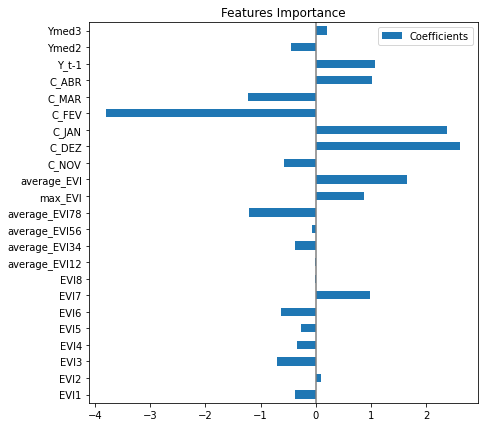

In [ ]:
#Checar a importância das features no modelo inicial

coefs = pd.DataFrame(
   LR.coef_[0:],
   columns=['Coefficients'], index=concat_data.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Features Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

**4.Feature Engineering - Deixei essa modelagem aqui pra que futuramente possam ser feitos outros testes com as features, novas features criadas, etc**

In [ ]:
#Teste modelagem
#Por enquanto vamos trabalhar com essas features no nosso modelo final

df4 = concat_data[['EVI6','average_EVI12','average_EVI34','max_EVI','Ymed2','Y_t-1']]
df4

,EVI6,average_EVI12,average_EVI34,max_EVI,Ymed2,Y_t-1
0,0.000000,5593.690208,0.000000,5593.690208,NaN,0.0
1,6057.176972,5196.027289,7179.113389,7409.062150,1470.0,2940.0
2,7016.344840,5124.442204,7262.550346,7698.649148,2940.0,2940.0
3,6321.926548,4848.897394,7330.956578,7749.662453,2912.5,2885.0
4,6870.044244,4538.038371,6850.128785,7209.192248,3032.5,3180.0
5,7113.561123,5140.012597,7125.157574,7415.473479,3090.0,3000.0
6,7150.740053,5077.597473,7278.460862,7871.699157,2759.0,2518.0
7,6700.152498,4834.086150,7115.928094,7987.367774,2609.0,2700.0
8,6998.788578,4460.829111,7273.614891,8162.761853,2850.0,3000.0
9,6204.238832,6069.359491,7925.070468,8271.898687,3150.0,3300.0


In [ ]:
#Treinar com exceção dos dados dos últimos 2 anos
Xtrain = df4.iloc[1:ano[-1]-2002,:].fillna(0)
Xtest =  df4.iloc[ano[-1]-2002:ano[-1]-2000,:].fillna(0)


LR: -440.562146 (92.339521)
RF: -379.110833 (138.975143)
SVR: -346.833333 (100.075249)
EL: -397.582060 (61.267228)
GBR: -394.432964 (100.596149)


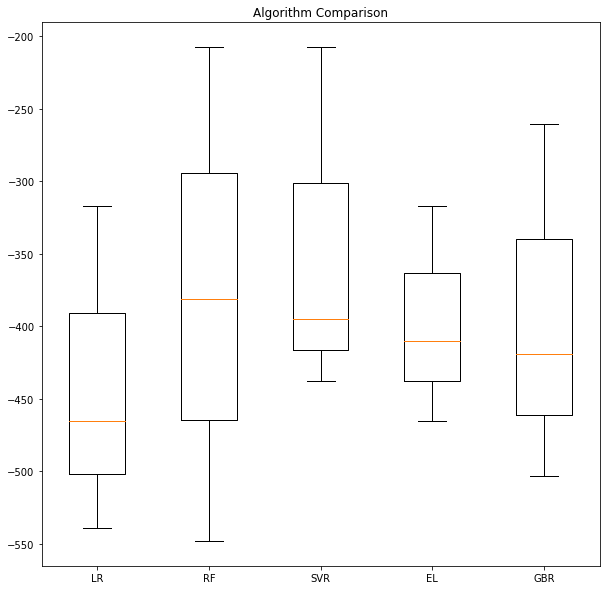

In [ ]:
# Comparar perfomance dos algoritmos de regressão
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor())) 
models.append(('SVR', SVR(gamma='auto'))) 
models.append(('EL',ElasticNet()))
models.append(('GBR',GradientBoostingRegressor(loss='absolute_error')))

# Avaliar cada modelo 
results = []
names = []
for name, model in models:
 # TimeSeries Cross validation - Não podemos utilizar K-Fold para validar um modelo temporal
 tscv = TimeSeriesSplit(n_splits=3)
    
 cv_results = cross_val_score(model, Xtrain, Ytrain, cv=tscv, scoring='neg_mean_absolute_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Plot Final
plt.figure(figsize=(10,10))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
# Regressão Linear GBR
GBR =  GradientBoostingRegressor(loss='absolute_error')
# fitting the training data
GBR.fit(Xtrain,Ytrain)
Y_GBR =  GBR.predict(Xtest)


# Regressão Linear GBR
RF =  RandomForestRegressor()
# fitting the training data
RF.fit(Xtrain,Ytrain)
Y_RF =  RF.predict(Xtest)

In [ ]:
# Teste de Acurácia das regressões
score=r2_score(Ytest,Y_GBR)
print("r2 Linear ",score)
print("mean_absolute_error Linear ==",mean_absolute_error(Ytest,Y_GBR))

score=r2_score(Ytest,Y_RF)
print("r2 Linear ",score)
print("mean_absolute_error Linear ==",mean_absolute_error(Ytest,Y_RF))


r2 Linear  -2050.6556405456254
mean_absolute_error Linear == 446.2341092749816
r2 Linear  -2359.6687584999995
mean_absolute_error Linear == 484.67499999999995


In [ ]:
#Previsão da Produtividade das últimas 2 safras
print("Produtividade Sidra:",Ytest)
print("Produtividade Estimada GBR:",GBR.predict(Xtest))
print("Produtividade Estimada Random Forest:",RF.predict(Xtest))



Produtividade Sidra: ['3700' '3720']
Produtividade Estimada GBR: [3176.04405483 3351.48772662]
Produtividade Estimada Random Forest: [3181.31 3269.34]


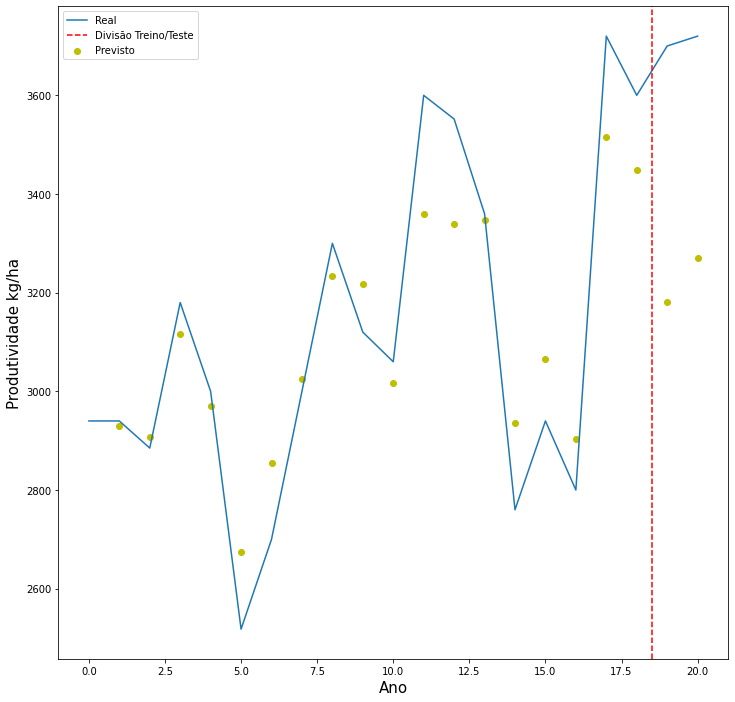

In [ ]:
plt.figure(figsize=(12,12))

#Plot Y Real
plt.plot(Y.astype(float))

#Plot Y Previsto
plt.scatter(tempox[1:-1],RF.predict(df4.iloc[1:ano[-1]-2000,:].fillna(0)),c = 'y')

plt.axvline(x=ano[-1]-2002.5, color='r', linestyle='--')

plt.legend(['Real','Divisão Treino/Teste','Previsto'])
plt.xlabel('Ano', fontsize=15)
plt.ylabel('Produtividade kg/ha', fontsize=15)



plt.show()

**5. Teste no XGBoost - Estado da Arte para Regressão**

In [ ]:
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=8, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, Xtrain, Ytrain, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -402.227 (175.811)


In [ ]:
model.fit(Xtrain,Ytrain)

[12:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
#Previsão da Produtividade das últimas 2 safras - sem tunar os hiperparâmetros
print("Produtividade Sidra:",Ytest)
print("Produtividade Estimada XGBRegressor:",model.predict(Xtest))

Produtividade Sidra: ['3700' '3720']
Produtividade Estimada XGBRegressor: [3116.6758 3325.3162]


**6. Otimizaçao de Hiperparâmetros**
Aqui fazemos uma otimização de hiperparâmetros.. modelos futuros podem variar também os hiperparâmetros testados




In [ ]:
#Inputs
dtrain = xgb.DMatrix(Xtrain, label=Ytrain)
dtest = xgb.DMatrix(Xtest, label=Ytest)

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.01,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [ ]:
params['eval_metric'] = "mae"
num_boost_round = 999


In [ ]:
#First Round
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[12:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:3680.01
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:3650.8
[2]	Test-mae:3621.87
[3]	Test-mae:3593.22
[4]	Test-mae:3564.83
[5]	Test-mae:3536.71
[6]	Test-mae:3508.86
[7]	Test-mae:3481.28
[8]	Test-mae:3453.95
[9]	Test-mae:3426.88
[10]	Test-mae:3400.07
[11]	Test-mae:3373.52
[12]	Test-mae:3347.21
[13]	Test-mae:3321.16
[14]	Test-mae:3295.35
[15]	Test-mae:3269.79
[16]	Test-mae:3244.47
[17]	Test-mae:3219.38
[18]	Test-mae:3194.54
[19]	Test-mae:3169.93
[20]	Test-mae:3145.56
[21]	Test-mae:3121.41
[22]	Test-mae:3097.49
[23]	Test-mae:3073.8
[24]	Test-mae:3050.34
[25]	Test-mae:3027.1
[26]	Test-mae:3004.07
[27]	Test-mae:2981.27
[28]	Test-mae:2958.68
[29]	Test-mae:2936.31
[30]	Test-mae:2914.15
[31]	Test-mae:2892.19
[32]	Test-mae:2870.45
[33]	Test-mae:2848.91
[34]	Test-mae:2827.58
[35]	Test-mae:2806.44
[36]	Test-mae:2785.51
[37]	Test-mae:27

In [ ]:
#Não é o ideal mas usamos kfold aqui na time series
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

cv_results

[12:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,3083.490527,40.307688,3084.113965,145.389341
1,3054.660107,39.932989,3055.283349,145.762454
2,3026.098975,39.562082,3026.722265,146.132219
3,2997.805078,39.195030,2998.428271,146.498352
4,2969.775781,38.831381,2970.398877,146.861283
...,...,...,...,...
321,193.359900,4.436030,388.550675,183.945063
322,191.929981,4.455314,388.592493,183.264372
323,190.494174,4.489478,388.505664,182.804764
324,189.089700,4.488810,388.580295,182.128284


In [ ]:
cv_results['test-mae-mean'].min()

388.37449640000006

In [ ]:
#Tunar Max_Depth e Min Child
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,7)
    for min_child_weight in range(1,7)
]

In [ ]:
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
[12:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 329.32717279999997 for 627 rounds
CV with max_depth=1, min_child_weight=2
[12:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:square

In [ ]:
#Tunar ETA

%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [1, .1, .05, .01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
CV with eta=1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 299.8045714 for 1 rounds

CV with eta=0.1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
[12:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [ ]:
#Final Params
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    # Other parameters
    'objective':'reg:linear',
}

In [ ]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")]
)

[12:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:3414.64
[1]	Test-rmse:3147.7
[2]	Test-rmse:2906.06
[3]	Test-rmse:2687.3
[4]	Test-rmse:2489.27
[5]	Test-rmse:2310
[6]	Test-rmse:2147.71
[7]	Test-rmse:2000.8
[8]	Test-rmse:1867.81
[9]	Test-rmse:1747.42
[10]	Test-rmse:1638.43
[11]	Test-rmse:1539.77
[12]	Test-rmse:1450.45
[13]	Test-rmse:1379.81
[14]	Test-rmse:1315.51
[15]	Test-rmse:1246.82
[16]	Test-rmse:1192.38
[17]	Test-rmse:1142.83
[18]	Test-rmse:1092.1
[19]	Test-rmse:1075.07
[20]	Test-rmse:1038.21
[21]	Test-rmse:1004.08
[22]	Test-rmse:953.844
[23]	Test-rmse:904.707
[24]	Test-rmse:896.226
[25]	Test-rmse:853.733
[26]	Test-rmse:817.836
[27]	Test-rmse:781.239
[28]	Test-rmse:747.396
[29]	Test-rmse:718.119
[30]	Test-rmse:691.045
[31]	Test-rmse:666.008
[32]	Test-rmse:642.856
[33]	Test-rmse:621.446
[34]	Test-rmse:601.648
[35]	Test-rmse:581.425
[36]	Test-rmse:562.556
[37]	Test-rmse:546.521
[38]	Test-rmse:5

In [ ]:
#Previsão da Produtividade das últimas 2 safras
print("Produtividade Sidra:",Ytest)
print("Produtividade Estimada XGB:",best_model.predict(dtest))

Produtividade Sidra: ['3700' '3720']
Produtividade Estimada XGB: [3279.5637 3440.1904]


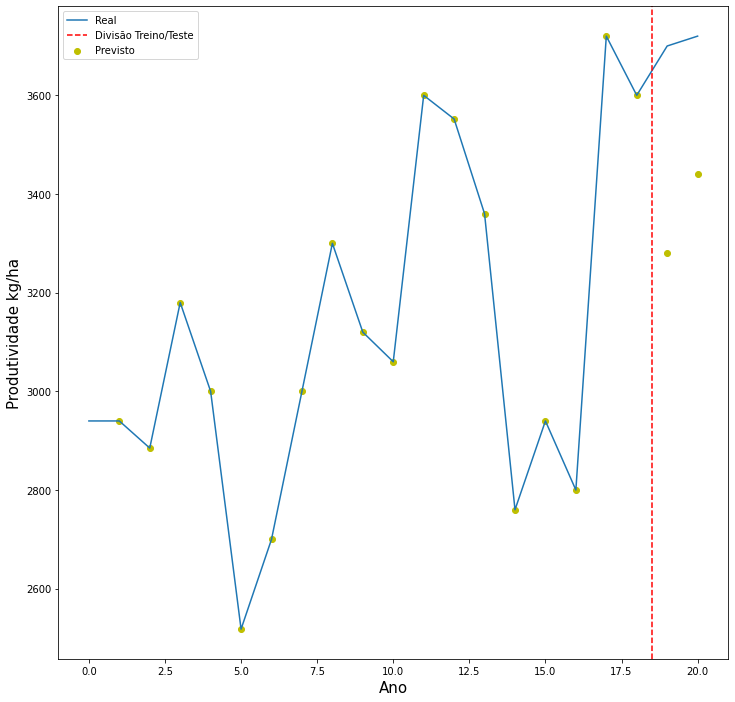

In [ ]:
plt.figure(figsize=(12,12))

#Plot Y Real
plt.plot(Y.astype(float))

d = xgb.DMatrix(df4.iloc[1:ano[-1]-2000,:].fillna(0), label=Y.astype(float))


#Plot Y Previsto
plt.scatter(tempox[1:-1],best_model.predict(d),c = 'y')

plt.axvline(x=ano[-1]-2002.5, color='r', linestyle='--')

plt.legend(['Real','Divisão Treino/Teste','Previsto'])
plt.xlabel('Ano', fontsize=15)
plt.ylabel('Produtividade kg/ha', fontsize=15)



plt.show()



In [ ]:
print(Y)
print(best_model.predict(d))

['2940' '2940' '2885' '3180' '3000' '2518' '2700' '3000' '3300' '3120'
 '3060' '3600' '3552' '3360' '2760' '2940' '2800' '3720' '3600' '3700'
 '3720']
[2939.9995 2885.0024 3179.9993 2999.9995 2517.9988 2699.9988 2999.9998
 3299.999  3119.9998 3060.     3599.9995 3552.0005 3359.9993 2760.0007
 2939.9998 2800.001  3719.9976 3599.9976 3279.5637 3440.1904]


**Sugestões de Melhoria:**
1. Utilização de outros satélites com séries mais antigas (Ex: Landsat)
2. Incorporação de outras features por satélite (Tmax, Pluviosidade)
3. Testar novos modelos/Otimizar hiperparâmetros
4. Testar estratégias de early stopping para ver se overfitta menos os modelos (Baixa disponibilidade de dados vai acabar overfitando mesmo)